### Imports and Function Definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
from matplotlib.colors import ListedColormap
import math
import random

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibrationDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, InputLayer, Add, Concatenate, Dropout, AlphaDropout
from tensorflow.keras.utils import plot_model
# from tensorflow_addons.activations import mish

plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])


In [2]:
def plot_history(history, *, n_epochs=None, plot_lr=False, title=None, bottom=None, top=None):
    """Plot (the last n_epochs epochs of) the training history
    
    Plots loss and optionally val_loss and lr."""
    plt.figure(figsize=(15, 6))
    from_epoch = 0 if n_epochs is None else max(len(history['loss']) - n_epochs, 0)
    
    # Plot training and validation losses
    plt.plot(np.arange(from_epoch, len(history['loss'])), history['loss'][from_epoch:], label='Training loss')
    try:
        plt.plot(np.arange(from_epoch, len(history['loss'])), history['val_loss'][from_epoch:], label='Validation loss')
        best_epoch = np.argmin(np.array(history['val_loss']))
        best_val_loss = history['val_loss'][best_epoch]
        if best_epoch >= from_epoch:
            plt.scatter([best_epoch], [best_val_loss], c='r', label=f'Best val_loss = {best_val_loss:.5f}')
        if best_epoch > 0:
            almost_epoch = np.argmin(np.array(history['val_loss'])[:best_epoch])
            almost_val_loss = history['val_loss'][almost_epoch]
            if almost_epoch >= from_epoch:
                plt.scatter([almost_epoch], [almost_val_loss], c='orange', label='Second best val_loss')
    except KeyError:
        pass
    if bottom is not None: plt.ylim(bottom=bottom)
    if top is not None: plt.ylim(top=top)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower left')
    if title is not None: plt.title(title)
        
    # Plot learning rate
    if plot_lr and 'lr' in history:
        ax2 = plt.gca().twinx()
        ax2.plot(np.arange(from_epoch, len(history['lr'])), np.array(history['lr'][from_epoch:]), color='g', label='Learning rate')
        ax2.set_ylabel('Learning rate')
        ax2.legend(loc='upper right')
        
    plt.show()

#### Creating Mish Activation 

In [3]:
import keras
from keras import backend as K
from keras.engine.base_layer import Layer
class Mish(Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
      

def mish(x):
    return keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)

#### Data Import and F.Eng

In [4]:
train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')

for i in range(10):
    train[f'ch{i}'] = train.f_27.str.get(i).apply(ord) - ord('A')
    test[f'ch{i}'] = test.f_27.str.get(i).apply(ord) - ord('A')
features = [f for f in test.columns if f != 'id' and f != 'f_27']

In [5]:
features = [f for f in test.columns if f != 'id' and f != 'f_27']
float_features = [f for f in features if test[f].dtype == float]
for df in [train, test]:
    # Extract the 10 letters of f_27 into individual features
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
        
    # unique_characters feature is from https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))
    
    # Feature interactions: create three ternary features
    # Every ternary feature can have the values -1, 0 and +1
    df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    
features = [f for f in test.columns if f != 'id' and f != 'f_27']
float_features = [f for f in features if test[f].dtype == float]
int_features = [f for f in features if test[f].dtype == int and f.startswith('f')]
ch_features = [f for f in features if f.startswith('ch')]
test[features].head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,ch4,ch5,ch6,ch7,ch8,ch9,unique_characters,i_02_21,i_05_22,i_00_01_26
0,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,...,1,0,3,11,0,2,5,0,0,1
1,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,...,1,0,4,6,2,1,6,0,0,0


#### Data Sampling & Memory Reduction

In [6]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

train = reduce_memory_usage(train, verbose=True)
test = reduce_memory_usage(test, verbose=True)

sample_df = train.sample(int(len(train) * 0.2))
sample_df.shape


Mem. usage decreased to 62.66 Mb (80.6% reduction)
Mem. usage decreased to 48.07 Mb (80.4% reduction)


(180000, 47)

#### EDA

plan: 
- univariate plots for features
- use plots and transform data if needed
- data projections --> splines? PCA?

In [7]:
# # If unique value < 10, consider categorical

# cat_variables = []

# for column in sample_df.columns:
#     if len(sample_df[column].unique()) < 10:
#         cat_variables.append(column)
# print(cat_variables)

In [8]:
# fig = plt.figure(figsize = (18, 30))

# for i in range(len(sample_df.columns.tolist()[:47])):
# #     if sample_df.columns.tolist()[:241][i] in [cat_variables]: 
# #         continue
#     if sample_df.columns.tolist()[:241][i] == 'f_27': 
#         continue
#     else:
#         plt.subplot(10,5,i+1)
#         sns.set_style("white")
#         plt.title(sample_df.columns.tolist()[:47][i], size = 12, fontname = 'monospace')
#         a = sns.kdeplot(sample_df[sample_df.columns.tolist()[:241][i]], color = '#1a5d57', shade = True, alpha = 0.9, linewidth = 1.5, edgecolor = 'black')
#         plt.ylabel('')
#         plt.xlabel('')
#         plt.xticks(fontname = 'monospace')
#         plt.yticks([])
#         for j in ['right', 'left', 'top']:
#             a.spines[j].set_visible(False)
#             a.spines['bottom'].set_linewidth(1.2)
        
# fig.tight_layout(h_pad = 3)

# plt.show()

#### Model Training

Next: 
- Try selu activation
- AlphaDropout
- SGD Optimizer


In [9]:
def my_model():
    """Simple sequential neural network with four hidden layers.
    
    Returns a (not yet compiled) instance of tensorflow.keras.models.Model.
    """
    activation = 'swish'
#     activation = 'selu'
#     activation = mish
    inputs = Input(shape=(len(features)-1))
#     inputs = Input(shape=(len(features)))
    x = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(40e-6),
              activation=activation,
              kernel_initializer='lecun_normal'
             )(inputs)
    x = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(40e-6),
              activation=activation,
              kernel_initializer='lecun_normal'
             )(x)
#     x = Dropout(0.2)(x)
#     x = AlphaDropout(0.1)(x)
    x = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(40e-6),
              activation=activation,
              kernel_initializer='lecun_normal'
             )(x) 
    x = Dense(32, kernel_regularizer=tf.keras.regularizers.l2(40e-6),
          activation=activation,
              kernel_initializer='lecun_normal'
             )(x)
    x = Dense(16, kernel_regularizer=tf.keras.regularizers.l2(40e-6),
              activation=activation,
              kernel_initializer='lecun_normal'
             )(x)
    x = Dense(1, #kernel_regularizer=tf.keras.regularizers.l2(1e-6),
              activation='sigmoid',
             )(x)
    model = Model(inputs, x)
    return model

44 features


2022-05-16 10:25:40.532655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 10:25:40.538591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 10:25:40.539359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 10:25:40.540797: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Fold 0.0 | 04:44 | Training loss: 0.0606 | Val loss: 0.0702 | AUC: 0.99783


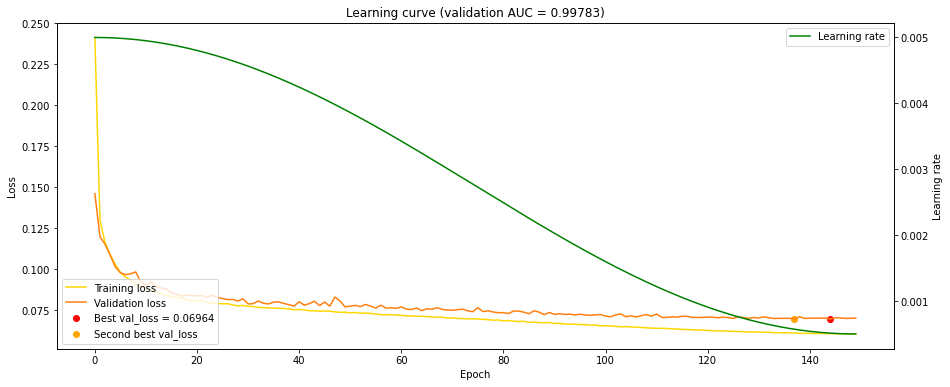

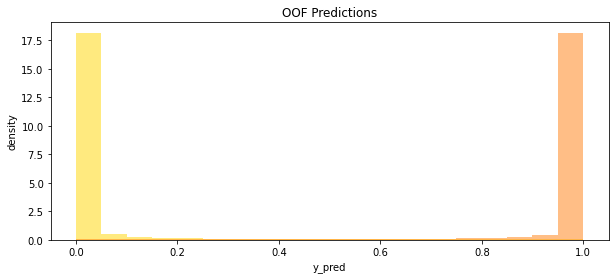

Fold 0.1 | 04:41 | Training loss: 0.0598 | Val loss: 0.0689 | AUC: 0.99793
Fold 0.2 | 04:40 | Training loss: 0.0600 | Val loss: 0.0689 | AUC: 0.99793
Fold 0.3 | 04:45 | Training loss: 0.0611 | Val loss: 0.0692 | AUC: 0.99791
Fold 0.4 | 05:23 | Training loss: 0.0611 | Val loss: 0.0692 | AUC: 0.99793
OOF AUC:                       0.99791
CPU times: user 32min 17s, sys: 2min 55s, total: 35min 12s
Wall time: 24min 37s


In [10]:
%%time
from sklearn.decomposition import PCA
# Cross-validation of the classifier

EPOCHS = 200
EPOCHS_COSINEDECAY = 150
CYCLES = 1
VERBOSE = 0 # set to 0 for less output, or to 2 for more output
DIAGRAMS = True
USE_PLATEAU = False
BATCH_SIZE = 2048
ONLY_FIRST_FOLD = False

# see https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

def fit_model(X_tr, y_tr, X_va=None, y_va=None, run=0):
    """Scale the data, fit a model, plot the training history and optionally validate the model
    
    Returns a trained instance of tensorflow.keras.models.Model.
    
    As a side effect, updates y_va_pred, history_list and score_list.
    """
    global y_va_pred
    start_time = datetime.datetime.now()
    
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    
    if X_va is not None:
        X_va = scaler.transform(X_va)
        validation_data = (X_va, y_va)
    else:
        validation_data = None

    # Define the learning rate schedule and EarlyStopping
    lr_start=0.005
    if USE_PLATEAU and X_va is not None: # use early stopping
        epochs = EPOCHS
        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.7, 
                               patience=4, verbose=VERBOSE)
        es = EarlyStopping(monitor="val_loss",
                           patience=12, 
                           verbose=1,
                           mode="min", 
                           restore_best_weights=True)
        callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]

    else: # use cosine learning rate decay rather than early stopping
        epochs = EPOCHS_COSINEDECAY
        lr_end = 0.0005
        def cosine_decay(epoch):
            # w decays from 1 to 0 in every cycle
            # epoch == 0                  -> w = 1 (first epoch of cycle)
            # epoch == epochs_per_cycle-1 -> w = 0 (last epoch of cycle)
            epochs_per_cycle = epochs // CYCLES
            epoch_in_cycle = epoch % epochs_per_cycle
            if epochs_per_cycle > 1:
                w = (1 + math.cos(epoch_in_cycle / (epochs_per_cycle-1) * math.pi)) / 2
            else:
                w = 1
            return w * lr_start + (1 - w) * lr_end

        lr = LearningRateScheduler(cosine_decay, verbose=0)
        callbacks = [lr, tf.keras.callbacks.TerminateOnNaN()]
        
    # Construct and compile the model
#     auc = tf.keras.metrics.AUC(
#             num_thresholds=100,
#             curve='ROC',
#             summation_method='interpolation',
#             name=None,
#             dtype=None,
#             thresholds=None,
#             multi_label=False,
#             num_labels=None,
#             label_weights=None,
#             from_logits=False
#         )
    model = my_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_start), 
                  metrics='AUC',
                  loss=tf.keras.losses.BinaryCrossentropy())

    # Train the model
    history = model.fit(X_tr, y_tr, 
                        validation_data=validation_data, 
                        epochs=epochs,
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)

    history_list.append(history.history)
    callbacks, es, lr, history = None, None, None, None
    
    if X_va is None:
        print(f"Training loss: {history_list[-1]['loss'][-1]:.4f}")
    else:
        lastloss = f"Training loss: {history_list[-1]['loss'][-1]:.4f} | Val loss: {history_list[-1]['val_loss'][-1]:.4f}"
        
        # Inference for validation
        y_va_pred = model.predict(X_va, batch_size=len(X_va), verbose=0)
        #oof_list[run][val_idx] = y_va_pred
        
        # Evaluation: Execution time, loss and AUC
        score = roc_auc_score(y_va, y_va_pred)
        print(f"Fold {run}.{fold} | {str(datetime.datetime.now() - start_time)[-12:-7]}"
              f" | {lastloss} | AUC: {score:.5f}")
        score_list.append(score)
        
        if DIAGRAMS and fold == 0 and run == 0:
#             Plot training history
            plot_history(history_list[-1], 
                         title=f"Learning curve (validation AUC = {score:.5f})",
                         plot_lr=True)

            # Plot y_true vs. y_pred
            plt.figure(figsize=(10, 4))
            plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
                     alpha=0.5, density=True)
            plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
                     alpha=0.5, density=True)
            plt.xlabel('y_pred')
            plt.ylabel('density')
            plt.title('OOF Predictions')
            plt.show()

    return model, scaler


print(f"{len(features)} features")
history_list = []
score_list = []
kf = KFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train)): 
    pca = PCA(n_components = 'mle')

    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = train.iloc[idx_tr].target
    y_va = train.iloc[idx_va].target
    
    X_tr_p = pca.fit_transform(X_tr)
    X_va_p = pca.transform(X_va)
#     fit_model(X_tr, y_tr, X_va, y_va)
    fit_model(X_tr_p, y_tr, X_va_p, y_va)
    if ONLY_FIRST_FOLD: break # we only need the first fold

print(f"OOF AUC:                       {np.mean(score_list):.5f}")

#### Submission

In [11]:
print(f"{len(features)} features")

X_tr = train[features]
y_tr = train.target

X_tr = pca.fit_transform(X_tr)
# X_va_p = pca.transform(X_va)


X_te = test[features]
X_te = pca.transform(X_te)

pred_list = []
for seed in range(10):
    # see https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    model, scaler = fit_model(X_tr, y_tr, run=seed)
    pred_list.append(scipy.stats.rankdata(model.predict(scaler.transform(X_te),
                                                        batch_size=len(X_te), verbose=0)))
    print(f"{seed:2}", pred_list[-1])
print()
submission = test[['id']].copy()
submission['target'] = np.array(pred_list).mean(axis=0)
submission.to_csv('submission.csv', index=False)
submission

44 features
Training loss: 0.0611
 0 [640896. 630108.  11278. ... 275451. 174984.  84506.]
Training loss: 0.0607
 1 [607929.5 601268.   12884.  ... 307642.  149198.    5001. ]
Training loss: 0.0608
 2 [601195.5 627122.    1360.  ... 310066.  161515.   21990. ]
Training loss: 0.0608
 3 [657945.5 620888.5   2598.  ... 317852.  102712.    6868. ]
Training loss: 0.0604
 4 [673430. 594576.  18159. ... 259620.  63224.  58197.]
Training loss: 0.0608
 5 [677988.  590513.5   3871.  ... 307599.    8378.   13412. ]
Training loss: 0.0604
 6 [641726. 568860.   8850. ... 312428.  62463.  89847.]
Training loss: 0.0606
 7 [587163.5 605137.5  17036.  ... 260209.  118092.    7288. ]
Training loss: 0.0610
 8 [632804. 618128.   8535. ... 310178. 183734.   4369.]
Training loss: 0.0607
 9 [613250. 654140.  75270. ... 310295. 162745. 137988.]



,id,target
0,900000,633432.80
1,900001,611074.15
2,900002,15984.10
3,900003,157798.45
4,900004,474070.55
...,...,...
699995,1599995,356842.90
699996,1599996,556481.60
699997,1599997,297134.00
699998,1599998,118704.50
